**Problem statement:** To build a CNN based model which can accurately detect the type of melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the type of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Read the data
Prior to running this notebook the source dataset should be copied to a folder called "Data" in the same folder

In [1]:
# Only used during testing
##!rm -r Data
##!cp -r Backup Data

/bin/bash: /home/kevandjo/miniconda3/envs/linux_tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/kevandjo/miniconda3/envs/linux_tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
# set the logging level to stop messages from the tensorflow library
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Importing all the important libraries

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import load_img

import warnings
warnings.filterwarnings('ignore')

This assignment uses a dataset of about 2239 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# The Train and test folders provided have been placed in a folder called data
# in the same folder as this jupyter notebook

# Defining the path for train and test images
data_dir_train = pathlib.Path("Data/Train")
data_dir_test = pathlib.Path("Data/Test")

In [5]:
# Lets count how many files are in each folder
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


Let's look at the number of images in each category

In [6]:
for folder in list(data_dir_train.glob('*')):
    label = str(folder)[11:]
    image_count_train = str(len(list(data_dir_train.glob(label+'/*.jpg'))))
    print(label,image_count_train)

actinic keratosis 114
basal cell carcinoma 376
dermatofibroma 95
melanoma 438
nevus 357
pigmented benign keratosis 462
seborrheic keratosis 77
squamous cell carcinoma 181
vascular lesion 139


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

In [8]:
# Lets check that tensorflow can see the GPU
tf.test.gpu_device_name()

#If a GPU is not found (the response is an empty string) this notebook will take a long time to execute

'/device:GPU:0'

Use 80% of the images for training, and 20% for validation.

In [9]:
# Load the data from the images into the dataset
# Use a consistant seed to ensure repeatability
# Resize all images to 180*180 and 3 channels to ensure consistency
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               labels='inferred',
                                                               seed=123,
                                                               batch_size=batch_size,
                                                               validation_split=0.2,
                                                               subset='training',
                                                               image_size=(img_height,img_width),
                                                               color_mode='rgb')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [10]:
# Repeat the data load process for the validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             labels='inferred',
                                                             seed=123,
                                                             batch_size=batch_size,
                                                             validation_split=0.2,
                                                             subset='validation',
                                                             image_size=(img_height,img_width),
                                                             color_mode='rgb')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [11]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### visualize one instance of all the nine classes present in the dataset

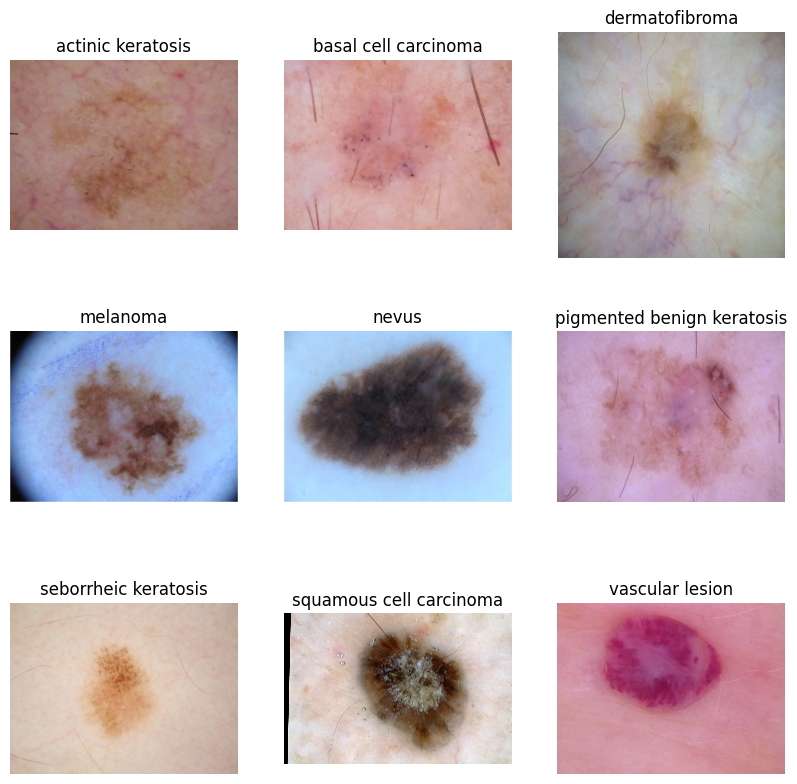

In [12]:
# for each of the class names load the first image from the folder with the same name
from glob import glob
i=0
plt.figure(figsize=(10, 10))
for c in class_names:
    images = glob(str(data_dir_test)+"/"+c+"/*")
    ax = plt.subplot(3, 3, i + 1)
    img = load_img(images[0])
    plt.imshow(img)
    plt.title(c)
    plt.axis("off")
    i+=1


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. 

In [14]:
# Create a simple sequential model
num_classes=9
model = Sequential()

# Normalisation layer
model.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer 1
model.add(Conv2D(32, kernel_size=(3, 1), padding='same',activation='relu'))
model.add(Conv2D(32, kernel_size=(1, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer 2
model.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer 3
model.add(Conv2D(128, kernel_size=(3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Convolution layer 4
model.add(Conv2D(256, kernel_size=(3, 3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Bottleneck layer
model.add(Conv2D(32, kernel_size=(1, 1), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flattern to a vector
model.add(Flatten())

# add dense layers
model.add(Dense(256,activation='relu'))
model.add(Dense(num_classes,activation='softmax'))



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
#Compile with the appropirate optimiser and loss function
model.compile(optimizer='Adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])


In [16]:
# Summary of all layers
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 180, 180, 32)      3104      
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 53ms/step - loss: 2.0609 - accuracy: 0.1970 - val_loss: 2.0338 - val_accuracy: 0.1499
Epoch 2/20
56/56 [==============================] - 2s 33ms/step - loss: 2.0252 - accuracy: 0.1992 - val_loss: 2.0182 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 2s 36ms/step - loss: 1.9627 - accuracy: 0.2511 - val_loss: 1.8456 - val_accuracy: 0.2975
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.6874 - accuracy: 0.3795 - val_loss: 1.6078 - val_accuracy: 0.3915
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.5473 - accuracy: 0.4537 - val_loss: 1.4698 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.4566 - accuracy: 0.4927 - val_loss: 1.5700 - val_accuracy: 0.4385
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.5029 - accuracy: 0.4710 - val_loss: 1.5876 - val_accuracy: 0.4228
Epoch 8/20
56

### Visualizing training results

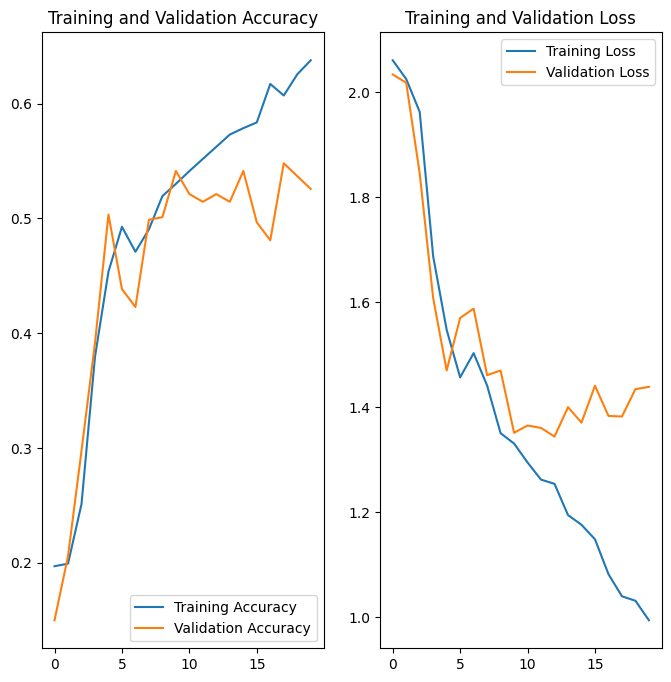

In [18]:
# cretae two plot comparing the training performance against the validation performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Plot the accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Findings
Looking at the plots, it's aparent that the model has overfitted the data.
The difference between the training accuracy and the validation accuracy indicates the model has 
memorised the training data and does not perform as well with unseen data

In [19]:
# To reduce overfitting we will transform the images as a layer in the model
# The transforms will be random so each epoch will be run using different variations
# of the images

# I will avoid skew and colour transformations. see the readme.md for more information
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomFlip("vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.4),
    layers.RandomZoom(0.1),
  ]
)


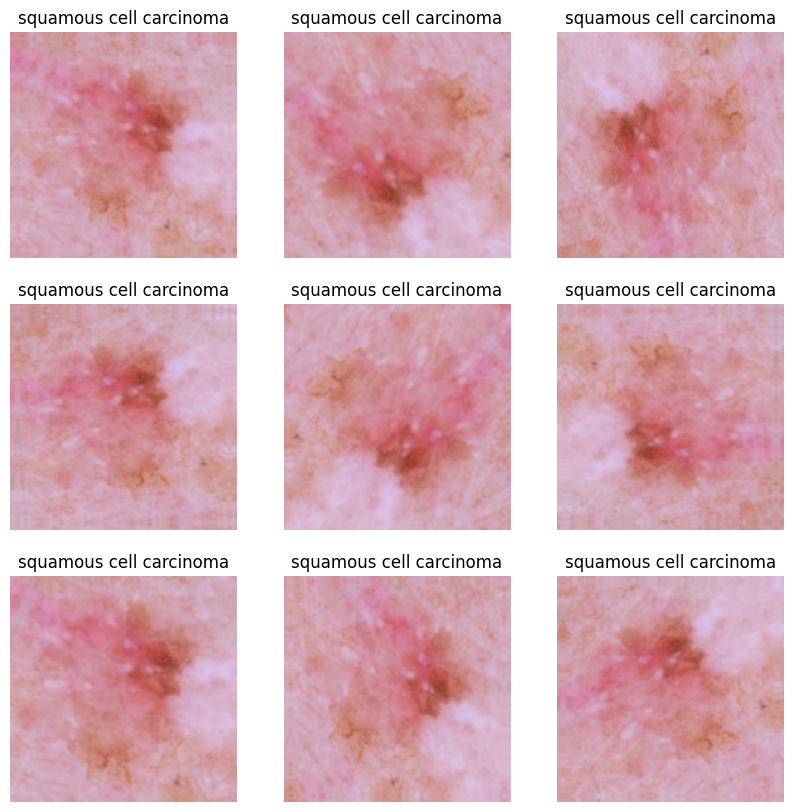

In [20]:
# visualize how the augmentation works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.title(class_names[labels[0]])
    plt.axis("off")




### Create, compile and train ta new model using in memory augmentation and dropouts to avoid overfitting


In [21]:
# Build a revised model to reduce overfitting
model2 = Sequential()
# transform in memory in each epoch
model2.add(data_augmentation)

# normalise the data
model2.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(180,180,3)))

# convolution layer 1
model2.add(Conv2D(32, kernel_size=(1, 3), padding='same',activation='relu'))
model2.add(Conv2D(32, kernel_size=(3, 1), padding='same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# convolution layer 2
model2.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# convolution layer 3
model2.add(Conv2D(128, kernel_size=(3, 3), padding='same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# convolution layer 4
model2.add(Conv2D(256, kernel_size=(3, 3), padding='same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# Bottleneck layer
model2.add(Conv2D(32, kernel_size=(1, 1), padding='same',activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))

# add a dropout layer to reduce overfitting
model2.add(Dropout(0.5))

# Flattern into a vector
model2.add(Flatten())

# add dense layers with dropout
model2.add(Dense(256,activation='relu'))
model2.add(Dropout(0.25))
model2.add(Dense(num_classes,activation='softmax'))





### Compiling the model

In [22]:
model2.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [23]:
# train the model for 20 epochs
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 44ms/step - loss: 2.0437 - accuracy: 0.2026 - val_loss: 1.9281 - val_accuracy: 0.2640
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.9681 - accuracy: 0.2606 - val_loss: 1.8448 - val_accuracy: 0.3177
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.8073 - accuracy: 0.3142 - val_loss: 1.8284 - val_accuracy: 0.3110
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.7843 - accuracy: 0.3432 - val_loss: 1.8039 - val_accuracy: 0.3221
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.7328 - accuracy: 0.3638 - val_loss: 1.6097 - val_accuracy: 0.4318
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.6502 - accuracy: 0.4023 - val_loss: 1.5685 - val_accuracy: 0.4407
Epoch 7/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6223 - accuracy: 0.4068 - val_loss: 1.5682 - val_accuracy: 0.4586
Epoch 8/20
56

### Visualizing the results

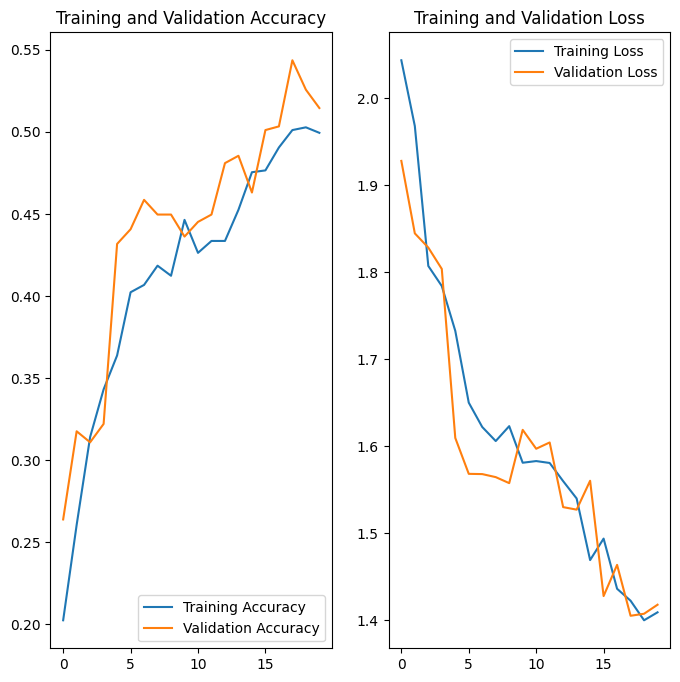

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plot the accuracy 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The overfitting has reduced.  This can be seen as the training and validation metrics are more closely aligned
#### The performance of the model is still poor (cerca 50%-55% accuracy)
#### This may be due to a class imbalance

#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [25]:
# calculate the number of sample in each classification folder
dist = pd.DataFrame(columns=['Label','Count'])
for folder in list(data_dir_train.glob('*')):
    label = str(folder)[11:]
    image_count_train = len(list(data_dir_train.glob(label+'/*.jpg')))
    dist.loc[len(dist)] =  [label,image_count_train]
print(dist)

                        Label  Count
0           actinic keratosis    114
1        basal cell carcinoma    376
2              dermatofibroma     95
3                    melanoma    438
4                       nevus    357
5  pigmented benign keratosis    462
6        seborrheic keratosis     77
7     squamous cell carcinoma    181
8             vascular lesion    139


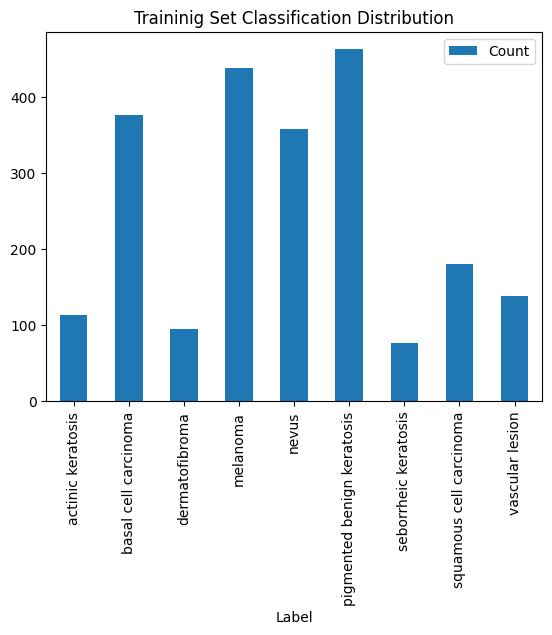

In [26]:
# Plot the distribution
dist.plot.bar(x='Label',y='Count')
plt.title('Traininig Set Classification Distribution')
plt.show()

#### **Findings** 
#### - There is a major imbalance in the source data
#### - Seborrheic keratosis has the fewest number of images in the source data with only 77
#### - At the other end of the scale, both melanoma and pigmented benign keratosis dominate the source data with 438 and 462 respectively
#### - This impacts the training of the model as the classifications that domainate the source data are more likely to be correct, so 
####   the model is more likely to prefer them druing training


#### **Approach:** To rectify the class imbalance I'll generate more source images by transforming images in the source dataset
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [27]:
# install the Augmentor library if required
!pip install Augmentor

/bin/bash: /home/kevandjo/miniconda3/envs/linux_tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)


To use `Augmentor`, I will follow this procedure:

1. Instantiate a `Pipeline` object pointing to a directory containing the initial image data set.<br>
2. Define a number of transformation operations to perform on this data set using the `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [28]:
# implement augmentation to the source data
path_to_training_dataset = "Data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Data/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2DB931AC40>: 100%|██████████| 500/500 [00:01<00:00, 393.90 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to Data/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2DB92BE910>: 100%|██████████| 500/500 [00:01<00:00, 405.37 Samples/s]


Initialised with 95 image(s) found.
Output directory set to Data/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F2DB92E09D0>: 100%|██████████| 500/500 [00:01<00:00, 383.91 Samples/s]


Initialised with 438 image(s) found.
Output directory set to Data/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F2D0C7E3490>: 100%|██████████| 500/500 [00:06<00:00, 82.73 Samples/s]                     


Initialised with 357 image(s) found.
Output directory set to Data/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2725x2082 at 0x7F2D0C5B6AC0>: 100%|██████████| 500/500 [00:05<00:00, 92.62 Samples/s]                   


Initialised with 462 image(s) found.
Output directory set to Data/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2D5FD17F10>: 100%|██████████| 500/500 [00:01<00:00, 441.48 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to Data/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F2CCB9B2FD0>: 100%|██████████| 500/500 [00:02<00:00, 178.24 Samples/s]                  


Initialised with 181 image(s) found.
Output directory set to Data/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2D0C4A35E0>: 100%|██████████| 500/500 [00:01<00:00, 415.32 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to Data/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F2D240C5DC0>: 100%|██████████| 500/500 [00:01<00:00, 406.20 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [29]:
# Count how many images have been created
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [30]:
# let's look at how many samples we have in each class now
dist = pd.DataFrame(columns=['Label','Count'])
for folder in list(data_dir_train.glob('*')):
    label = str(folder)[11:]
    image_count_train = len(list(data_dir_train.glob(label+'/*.jpg')))
    image_count_train += len(list(data_dir_train.glob(label+'/output/*.jpg')))
    dist.loc[len(dist)] =  [label,image_count_train]
print(dist)

                        Label  Count
0           actinic keratosis    614
1        basal cell carcinoma    876
2              dermatofibroma    595
3                    melanoma    938
4                       nevus    857
5  pigmented benign keratosis    962
6        seborrheic keratosis    577
7     squamous cell carcinoma    681
8             vascular lesion    639


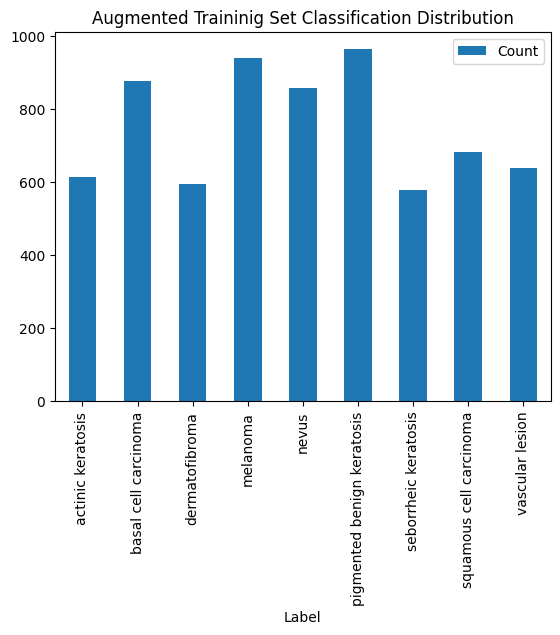

In [31]:
# Plot the distribution
dist.plot.bar(x='Label',y='Count')
plt.title('Augmented Traininig Set Classification Distribution')
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the augmented data

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### Reload the training dataset with the augmented data

In [33]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Reload the validation dataset with the augmented data

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [35]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### create another model using the augmented data source

In [36]:
model3 = Sequential()

# no need to augment the data in memory as we have augmented in source

# we still need to normalise the data
model3.add(layers.experimental.preprocessing.Rescaling(scale=1./255,input_shape=(180,180,3)))

# convolution layer 1
model3.add(Conv2D(32, kernel_size=(1, 3), padding='same',activation='relu'))
model3.add(Conv2D(32, kernel_size=(3, 1), padding='same',activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# convolution layer 2
model3.add(Conv2D(64, kernel_size=(3, 3), padding='same',activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# convolution layer 3
model3.add(Conv2D(128, kernel_size=(3, 3), padding='same',activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# convolution layer 4
model3.add(Conv2D(256, kernel_size=(3, 3), padding='same',activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# bottleneck layer
model3.add(Conv2D(32, kernel_size=(1, 1), padding='same',activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# implement a dropout to reduce overfitting
model3.add(Dropout(0.5))

# flattern to a vector
model3.add(Flatten())

# add dense layers with dropout
model3.add(Dense(256,activation='relu'))
model3.add(Dropout(0.25))
model3.add(Dense(num_classes,activation='softmax'))


#### Compile the model

In [37]:
model3.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

#### Train the model with the new dataset and more epochs

In [38]:
epochs = 50
# train with 50 epochs.
history = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 13s 49ms/step - loss: 2.1083 - accuracy: 0.1664 - val_loss: 1.7887 - val_accuracy: 0.2866
Epoch 2/50
169/169 [==============================] - 6s 37ms/step - loss: 1.7998 - accuracy: 0.2810 - val_loss: 1.6643 - val_accuracy: 0.3237
Epoch 3/50
169/169 [==============================] - 6s 37ms/step - loss: 1.6242 - accuracy: 0.3648 - val_loss: 1.4256 - val_accuracy: 0.4321
Epoch 4/50
169/169 [==============================] - 6s 38ms/step - loss: 1.5084 - accuracy: 0.4110 - val_loss: 1.4071 - val_accuracy: 0.4469
Epoch 5/50
169/169 [==============================] - 6s 37ms/step - loss: 1.4310 - accuracy: 0.4538 - val_loss: 1.3871 - val_accuracy: 0.4506
Epoch 6/50
169/169 [==============================] - 6s 37ms/step - loss: 1.3654 - accuracy: 0.4768 - val_loss: 1.3007 - val_accuracy: 0.5041
Epoch 7/50
169/169 [==============================] - 6s 36ms/step - loss: 1.3380 - accuracy: 0.4826 - val_loss: 1.2091 - val_accuracy: 0.534

#### Visualize the model results

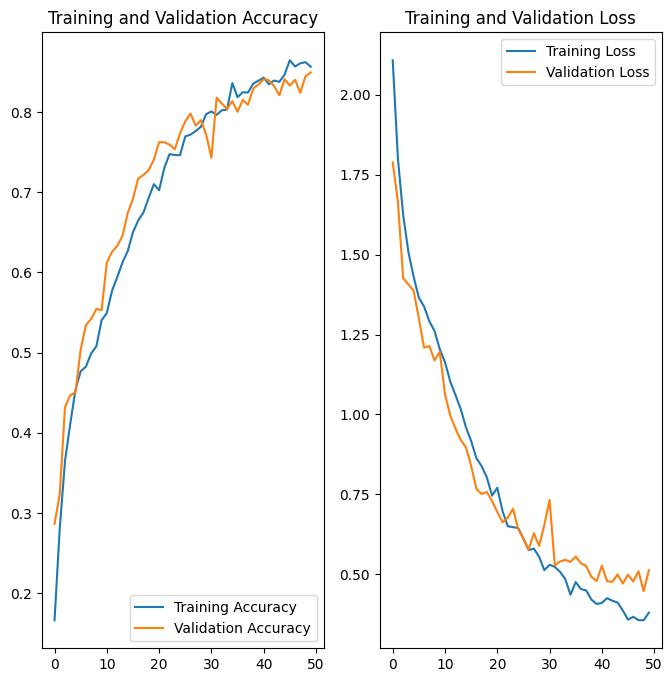

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plot the accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# plot the loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### The rebalance of the data and increasing the number of epochs has vastly improved the performance of the model
- The overfitting has reduced further with the training and validation metrics now more closely aligned
- the validation accuracy has increased to 80% to 85%
- the validation loss has also more than halved
- I believe I could improve the accuracy by increasing the size of the dense layers (but this would increase the number of parameters)
- The accuracy could also be increased by tuning the hyperparameters or by reducing the learning rate during training
